# Notebook for Supervised ML: Predicting dynamics

Code generated with: https://chatgpt.com/share/687e8e4d-d5cc-8011-9fb9-76572b71678f

Code of original paper: https://github.com/clegaard/deep_learning_for_dynamical_systems/blob/main/

Consider the time-series data of a pendulum of length $l$ in the gravitational field with $g$ the acceleration, for example, due to the planet Earth. The following ODE describes this system: 

\begin{equation}
\ddot \phi
+\frac{g}{l} \sin \phi =0,
\end{equation}

where the state variables are the angular displacement $\phi$ and angular velocity $\dot\phi$. 

Now, direct-solution models, given some collocation points (red dots in the Figure below) in the trajectory data can be trained with a simple ANNs (see: (Legaard et al., 2023). Most directly, a densely connected ANN ($\mathcal{N}:\mathbb{R} \rightarrow \mathbb{R}^2$) with 3 hidden layers can model $\boldsymbol{y} = (\phi, \dot\phi) = \mathcal{N}(t)$:

$$
h^{[0]} = t \in \mathbb{R}
$$

$$
h^{[1]} = f^{[1]}(W^{[1]} h^{[0]} + b^{[1]}) \in \mathbb{R}^{32}
$$

$$
W^{[1]} \in \mathbb{R}^{32 \times 1}, \quad b^{[1]} \in \mathbb{R}^{32}
$$

$$
h^{[2]} = f^{[2]}(W^{[2]} h^{[1]} + b^{[2]}) \in \mathbb{R}^{32}
$$

$$
W^{[2]} \in \mathbb{R}^{32 \times 32}, \quad b^{[2]} \in \mathbb{R}^{32}
$$

$$
h^{[3]} = f^{[3]}(W^{[3]} h^{[2]} + b^{[3]}) \in \mathbb{R}^{2}
$$

$$
W^{[3]} \in \mathbb{R}^{2 \times 32}, \quad b^{[3]} \in \mathbb{R}^{2}
$$

$$
y = h^{[3]}
$$
The weights $\boldsymbol{W}$ and $\boldsymbol{b}$ can be found with gradient descent of $\mathcal{L}_{\text{MSE}}$ and training data ($t^{(i)}$). This is a purely data-driven approach, agnostic of any physics knowledge or expertise that might be known about the system.

An approach that recognizes the physics, encapsulated by the ODE, are PINNs. Here, the loss function is comprised of data loss ($\mathcal{L}_{\text{MSE}}$), and equation loss ($\mathcal{L}_{\text{eq}}=\mathcal{L}_{\text{ODE}}$):

\begin{equation}
\mathcal{L}_{\text{ODE}} = \frac{1}{n} \sum_{j=1}^{n} \left( \ddot \phi(t^{(j)})
+\frac{g}{l} \sin \phi(t^{(j)}) \right)^2.  
\end{equation}

The second derivative can be calculated using automatic differentiation.

The igure below indicates that while the ANN can in fact learn to fit the collocation points well, the physics behavior is quite unreasonable. On the other hand, the PINN is constrained to fit the physics much more accurately (though the data loss might be greater) (For more physics-based modeling options on this problem, see (Legaard et al., 2023).

In [3]:
# --------------------- Import necessary libraries ---------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim

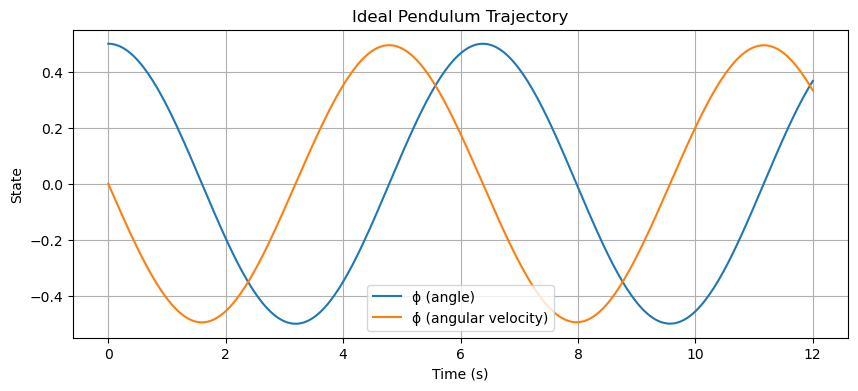

In [4]:
# --------------------- Simulate and plot data ---------------------

g = 1.0      # gravity (m/s^2)
l = 1.0      # pendulum length (m)

t_span = (0, 12)  # total simulation time
t_eval = np.linspace(*t_span, 300)  # times to evaluate

# Initial conditions: phi = 0.5 rad, phi_dot = 0.0 rad/s
x0 = [0.5, 0.0]

# Pendulum ODE system
def pendulum_ode(t, y):
    phi, phi_dot = y
    dphi_dt = phi_dot
    dphi_dot_dt = - (g / l) * np.sin(phi)
    return [dphi_dt, dphi_dot_dt]

# Simulate trajectory
sol = solve_ivp(pendulum_ode, t_span, x0, t_eval=t_eval, method='RK45')
phi, phi_dot = sol.y

# Plot trajectory
plt.figure(figsize=(10, 4))
plt.plot(sol.t, phi, label='ϕ (angle)')
plt.plot(sol.t, phi_dot, label='ϕ̇ (angular velocity)')
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('Ideal Pendulum Trajectory')
plt.legend()
plt.grid(True)
plt.show()

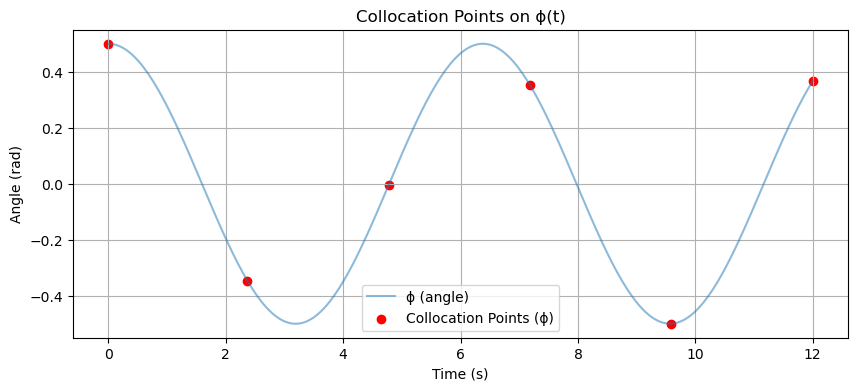

In [5]:
# Select collocation points
num_collocation = 6
collocation_idx = np.linspace(0, len(t_eval)-1, num_collocation, dtype=int)

t_collocation = t_eval[collocation_idx]
phi_collocation = phi[collocation_idx]
phi_dot_collocation = phi_dot[collocation_idx]

# Plot collocation points
plt.figure(figsize=(10, 4))
plt.plot(t_eval, phi, label='ϕ (angle)', alpha=0.5)
plt.scatter(t_collocation, phi_collocation, color='red', label='Collocation Points (ϕ)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Collocation Points on ϕ(t)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# hyperparameters:
epochs = 10000

## Train and evaluate vanilla direct model

In [12]:
# Prepare training data (collocation points)
t_train = torch.tensor(t_collocation, dtype=torch.float32).unsqueeze(1)  # shape (N, 1)
y_train = torch.tensor(np.vstack([phi_collocation, phi_dot_collocation]).T, dtype=torch.float32)  # shape (N, 2)

# Define the network
class VanillaDirectNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 2)  # output: [phi, phi_dot]
        )
    def forward(self, t):
        return self.net(t)

# Instantiate model, optimizer and loss
model = VanillaDirectNN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Train model
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(t_train)
    loss = loss_fn(pred, y_train)
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 0.634914
Epoch 500: Loss = 0.082432
Epoch 1000: Loss = 0.049851
Epoch 1500: Loss = 0.022863
Epoch 2000: Loss = 0.001085
Epoch 2500: Loss = 0.000102
Epoch 3000: Loss = 0.000000
Epoch 3500: Loss = 0.000000
Epoch 4000: Loss = 0.000019
Epoch 4500: Loss = 0.000000
Epoch 5000: Loss = 0.000005
Epoch 5500: Loss = 0.000000
Epoch 6000: Loss = 0.000006
Epoch 6500: Loss = 0.000000
Epoch 7000: Loss = 0.000000
Epoch 7500: Loss = 0.000002
Epoch 8000: Loss = 0.000000
Epoch 8500: Loss = 0.000009
Epoch 9000: Loss = 0.000000
Epoch 9500: Loss = 0.000000


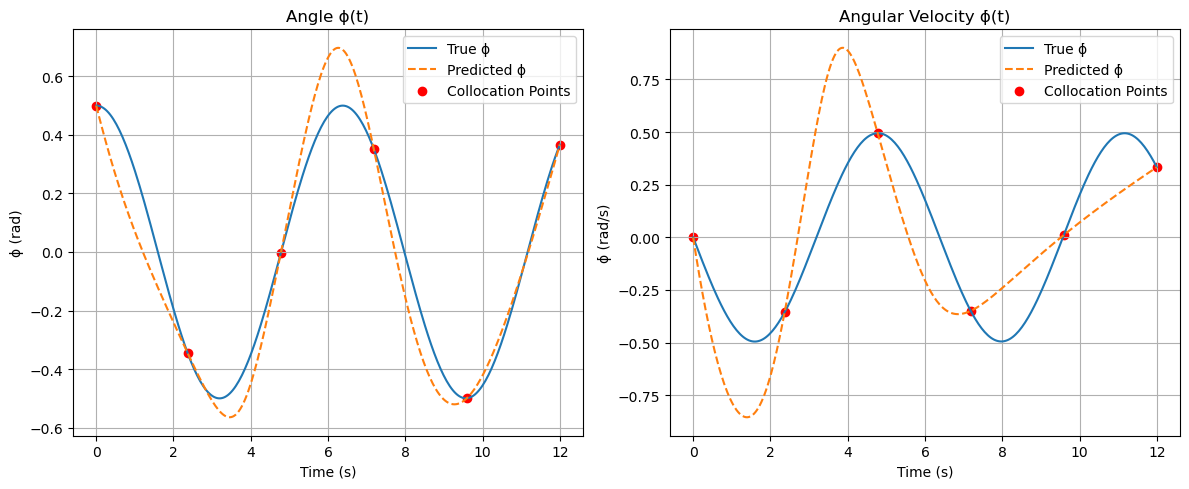

In [13]:
# Evaluate model on full time domain
model.eval()
with torch.no_grad():
    t_full = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1)
    y_pred = model(t_full).numpy()

# Extract predictions
phi_pred, phi_dot_pred = y_pred.T
phi_direct_pred, phi_dot_direct_pred = y_pred.T

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, phi, label='True ϕ')
plt.plot(t_eval, phi_pred, '--', label='Predicted ϕ')
plt.scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
plt.title('Angle ϕ(t)')
plt.xlabel('Time (s)')
plt.ylabel('ϕ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, phi_dot, label='True ϕ̇')
plt.plot(t_eval, phi_dot_pred, '--', label='Predicted ϕ̇')
plt.scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
plt.title('Angular Velocity ϕ̇(t)')
plt.xlabel('Time (s)')
plt.ylabel('ϕ̇ (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Auto-differentiation direct model

In [15]:
# Define the network: maps t → phi
class AutoDiffDirectNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 1)  # output: phi only
        )
    def forward(self, t):
        return self.net(t)

# Instantiate model, optimizer and loss
model_ad = AutoDiffDirectNN()
optimizer_ad = optim.Adam(model_ad.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [16]:
# Enable gradient tracking for t
t_train_ad = t_train.clone().detach().requires_grad_(True)
phi_true = torch.tensor(phi_collocation, dtype=torch.float32).unsqueeze(1)
phi_dot_true = torch.tensor(phi_dot_collocation, dtype=torch.float32).unsqueeze(1)

# Training
for epoch in range(epochs):
    model_ad.train()
    optimizer_ad.zero_grad()

    # Predict ϕ
    phi_pred = model_ad(t_train_ad)

    # Compute ϕ̇ = dϕ/dt using autograd
    phi_dot_pred = torch.autograd.grad(
        phi_pred, t_train_ad,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]

    # Compute combined loss
    loss_phi = loss_fn(phi_pred, phi_true)
    loss_phi_dot = loss_fn(phi_dot_pred, phi_dot_true)
    loss = loss_phi + loss_phi_dot

    loss.backward()
    optimizer_ad.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

Epoch 0: Loss = 1.888041
Epoch 500: Loss = 0.202444
Epoch 1000: Loss = 0.149476
Epoch 1500: Loss = 0.007613
Epoch 2000: Loss = 0.004752
Epoch 2500: Loss = 0.002973
Epoch 3000: Loss = 0.001957
Epoch 3500: Loss = 0.001198
Epoch 4000: Loss = 0.000643
Epoch 4500: Loss = 0.000284
Epoch 5000: Loss = 0.000112
Epoch 5500: Loss = 0.000061
Epoch 6000: Loss = 0.000019
Epoch 6500: Loss = 0.000009
Epoch 7000: Loss = 0.000085
Epoch 7500: Loss = 0.000003
Epoch 8000: Loss = 0.000329
Epoch 8500: Loss = 0.000129
Epoch 9000: Loss = 0.000001
Epoch 9500: Loss = 0.000001


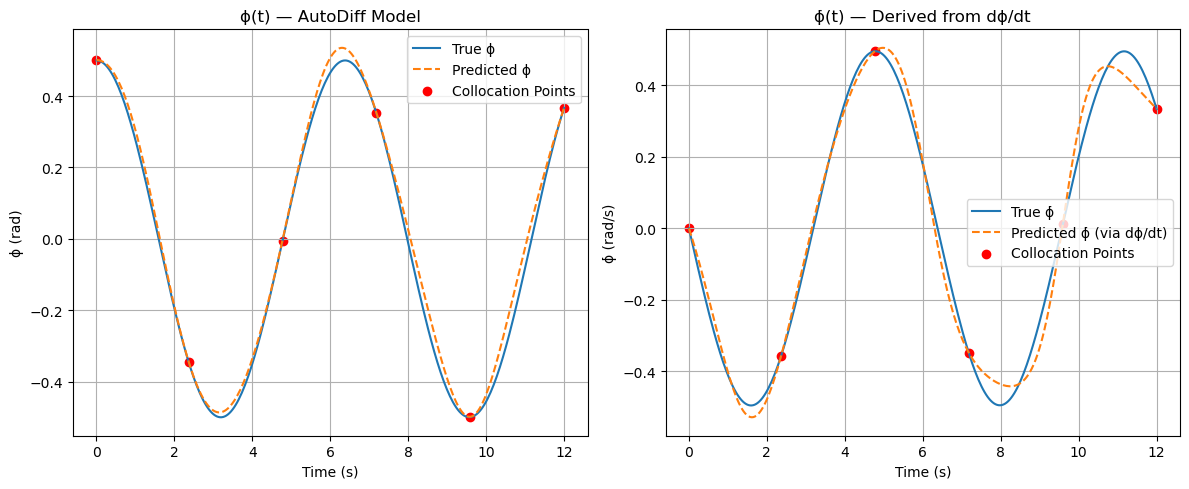

In [17]:
# Evaluate on full time domain
t_full_ad = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1).requires_grad_(True)

with torch.no_grad():
    phi_full_pred = model_ad(t_full_ad)

# Re-enable gradients for ϕ̇ computation
phi_full_pred = model_ad(t_full_ad)
phi_dot_full_pred = torch.autograd.grad(
    phi_full_pred, t_full_ad,
    grad_outputs=torch.ones_like(phi_full_pred),
    create_graph=False
)[0]

# Convert to NumPy
phi_pred_ad = phi_full_pred.detach().numpy().flatten()
phi_dot_pred_ad = phi_dot_full_pred.detach().numpy().flatten()

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, phi, label='True ϕ')
plt.plot(t_eval, phi_pred_ad, '--', label='Predicted ϕ')
plt.scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
plt.title('ϕ(t) — AutoDiff Model')
plt.xlabel('Time (s)')
plt.ylabel('ϕ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, phi_dot, label='True ϕ̇')
plt.plot(t_eval, phi_dot_pred_ad, '--', label='Predicted ϕ̇ (via dϕ/dt)')
plt.scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
plt.title('ϕ̇(t) — Derived from dϕ/dt')
plt.xlabel('Time (s)')
plt.ylabel('ϕ̇ (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## PINN

In [44]:
# Reuse previous network that outputs only θ
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Softplus(),
            nn.Linear(32, 32),
            nn.Softplus(),
            nn.Linear(32, 1)
        )
    def forward(self, t):
        return self.net(t)

model_pinn = PINN()
optimizer_pinn = optim.Adam(model_pinn.parameters(), lr=1e-3)

In [45]:
# Inputs for training with gradients
t_train_pinn = t_train.clone().detach().requires_grad_(True)

# Ground-truth values at collocation points
phi_true = torch.tensor(phi_collocation, dtype=torch.float32).unsqueeze(1)
phi_dot_true = torch.tensor(phi_dot_collocation, dtype=torch.float32).unsqueeze(1)

In [46]:
for epoch in range(epochs):
    model_pinn.train()
    optimizer_pinn.zero_grad()

    # Predict ϕ
    phi_pred = model_pinn(t_train_pinn)

    # ϕ̇ = dϕ/dt
    phi_dot_pred = torch.autograd.grad(
        phi_pred, t_train_pinn,
        grad_outputs=torch.ones_like(phi_pred),
        create_graph=True
    )[0]

    # dϕ̇/dt = d²ϕ/dt²
    dphi_dot_dt = torch.autograd.grad(
        phi_dot_pred, t_train_pinn,
        grad_outputs=torch.ones_like(phi_dot_pred),
        create_graph=True
    )[0]

    # Physics-informed residual: dϕ̇/dt + (g/l) * sin(ϕ) = 0
    physics_residual = dphi_dot_dt + (g / l) * torch.sin(phi_pred)

    # Loss terms
    loss_collocation = loss_fn(phi_pred, phi_true) + loss_fn(phi_dot_pred, phi_dot_true)
    loss_physics = loss_fn(physics_residual, torch.zeros_like(physics_residual))

    # Total loss
    loss = loss_collocation + loss_physics

    loss.backward()
    optimizer_pinn.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Total Loss = {loss.item():.6f} | Data = {loss_collocation.item():.6f} | Physics = {loss_physics.item():.6f}")

Epoch 0: Total Loss = 0.252554 | Data = 0.251813 | Physics = 0.000742
Epoch 500: Total Loss = 0.145529 | Data = 0.137416 | Physics = 0.008112
Epoch 1000: Total Loss = 0.032084 | Data = 0.022113 | Physics = 0.009971
Epoch 1500: Total Loss = 0.020401 | Data = 0.010875 | Physics = 0.009526
Epoch 2000: Total Loss = 0.018929 | Data = 0.010123 | Physics = 0.008806
Epoch 2500: Total Loss = 0.017308 | Data = 0.009038 | Physics = 0.008271
Epoch 3000: Total Loss = 0.015892 | Data = 0.008242 | Physics = 0.007650
Epoch 3500: Total Loss = 0.014501 | Data = 0.007424 | Physics = 0.007077
Epoch 4000: Total Loss = 0.013126 | Data = 0.006650 | Physics = 0.006476
Epoch 4500: Total Loss = 0.011749 | Data = 0.005919 | Physics = 0.005829
Epoch 5000: Total Loss = 0.012647 | Data = 0.007607 | Physics = 0.005040
Epoch 5500: Total Loss = 0.009902 | Data = 0.004325 | Physics = 0.005577
Epoch 6000: Total Loss = 0.008212 | Data = 0.004141 | Physics = 0.004071
Epoch 6500: Total Loss = 0.007597 | Data = 0.004241 | P

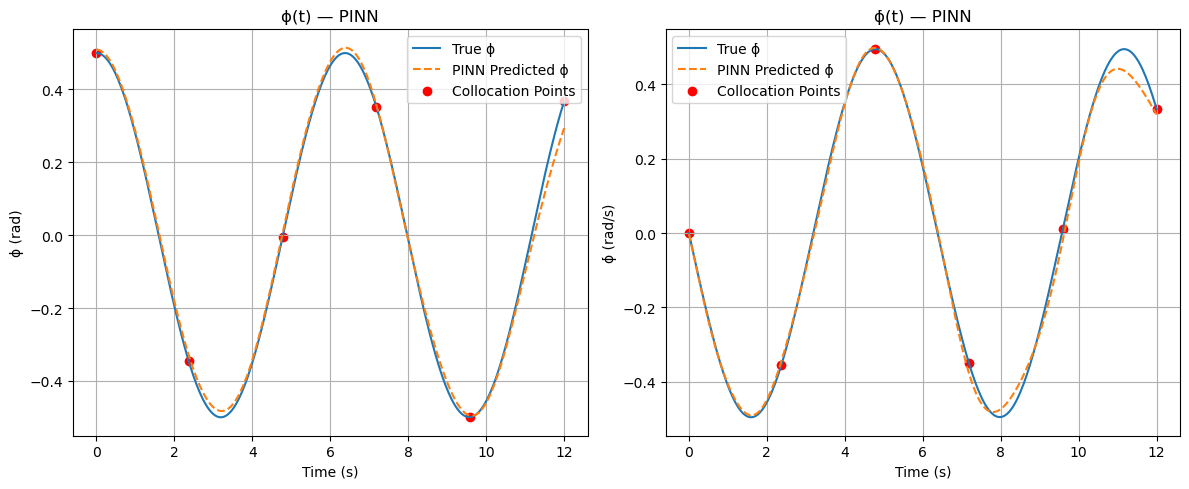

In [47]:
# Evaluation over full time domain
t_full = torch.tensor(t_eval, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
phi_pred_full = model_pinn(t_full)

# ϕ̇ = dϕ/dt
phi_dot_pred_full = torch.autograd.grad(
    phi_pred_full, t_full,
    grad_outputs=torch.ones_like(phi_pred_full),
    create_graph=False
)[0]

phi_pinn = phi_pred_full.detach().numpy().flatten()
phi_dot_pinn = phi_dot_pred_full.detach().numpy().flatten()

phi_pinn_pred = phi_pinn
phi_dot_pinn_pred = phi_dot_pinn

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t_eval, phi, label='True ϕ')
plt.plot(t_eval, phi_pinn, '--', label='PINN Predicted ϕ')
plt.scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
plt.title('ϕ(t) — PINN')
plt.xlabel('Time (s)')
plt.ylabel('ϕ (rad)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(t_eval, phi_dot, label='True ϕ̇')
plt.plot(t_eval, phi_dot_pinn, '--', label='PINN Predicted ϕ̇')
plt.scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
plt.title('ϕ̇(t) — PINN')
plt.xlabel('Time (s)')
plt.ylabel('ϕ̇ (rad/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Plot for article

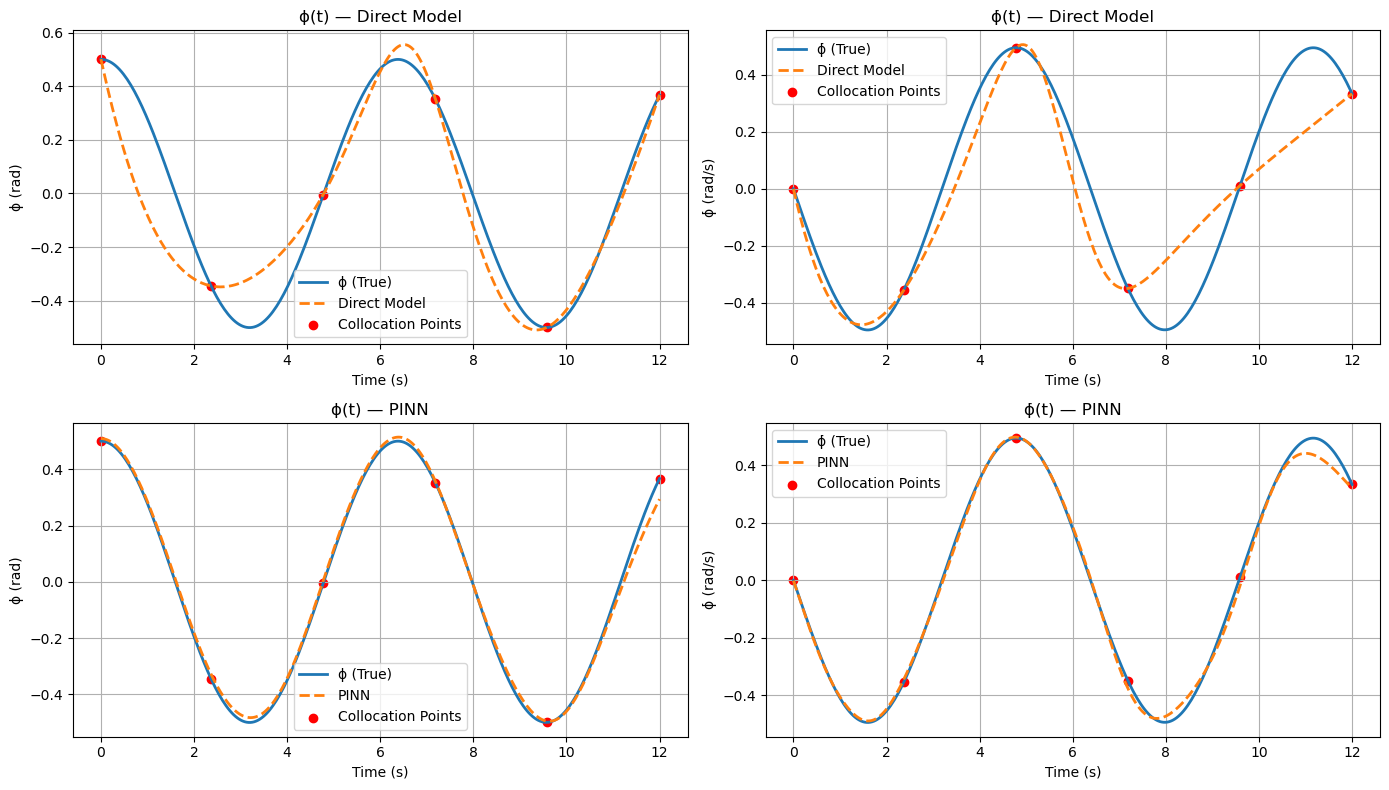

In [57]:
# Ensure all collocation arrays are 1D for plotting
phi_collocation = phi_collocation.flatten()
phi_dot_collocation = phi_dot_collocation.flatten()

# Plot only Direct model and PINN model
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# --- Row 1 (was Row 2): Direct model ---
axs[0, 0].plot(t_eval, phi, label='ϕ (True)', linewidth=2)
axs[0, 0].plot(t_eval, phi_direct_pred, '--', label='Direct Model', linewidth=2)
axs[0, 0].scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
axs[0, 0].set_title('ϕ(t) — Direct Model')
axs[0, 0].set_xlabel('Time (s)')
axs[0, 0].set_ylabel('ϕ (rad)')
axs[0, 0].legend()
axs[0, 0].grid(True)

axs[0, 1].plot(t_eval, phi_dot, label='ϕ̇ (True)', linewidth=2)
axs[0, 1].plot(t_eval, phi_dot_direct_pred, '--', label='Direct Model', linewidth=2)
axs[0, 1].scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
axs[0, 1].set_title('ϕ̇(t) — Direct Model')
axs[0, 1].set_xlabel('Time (s)')
axs[0, 1].set_ylabel('ϕ̇ (rad/s)')
axs[0, 1].legend()
axs[0, 1].grid(True)

# --- Row 2 (was Row 3): PINN model ---
axs[1, 0].plot(t_eval, phi, label='ϕ (True)', linewidth=2)
axs[1, 0].plot(t_eval, phi_pinn_pred, '--', label='PINN', linewidth=2)
axs[1, 0].scatter(t_collocation, phi_collocation, c='red', label='Collocation Points')
axs[1, 0].set_title('ϕ(t) — PINN')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('ϕ (rad)')
axs[1, 0].legend()
axs[1, 0].grid(True)

axs[1, 1].plot(t_eval, phi_dot, label='ϕ̇ (True)', linewidth=2)
axs[1, 1].plot(t_eval, phi_dot_pinn_pred, '--', label='PINN', linewidth=2)
axs[1, 1].scatter(t_collocation, phi_dot_collocation, c='red', label='Collocation Points')
axs[1, 1].set_title('ϕ̇(t) — PINN')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('ϕ̇ (rad/s)')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust vertical spacing between rows
plt.subplots_adjust(hspace=0.4)  # You can increase this value for more spacing

plt.tight_layout()
plt.show()